# Pint - Quick Tutorial

This document aims at giving a brief tutorial for Pint usage through its Python API.
A more complete tutorial can be found at http://loicpauleve.name/pint/doc.

## Installation

Pint is distributed as binaries for Ubuntu/Debian and Mac OS X.
A docker image which contains all dependencies and the Jupyter notebook is also available.
Adventurous users can also install Pint from [sources](https://github.com/pauleve/pint).

### From binaries (Ubuntu or Mac OS X)

*Ubuntu* users can download and install the package  [pint_2017-04-13_amd64.deb](https://github.com/pauleve/pint/releases/download/2017-04-13/pint_2017-04-13_amd64.deb)

*Mac OS X* users can download and open the image [pint-2017-04-13.dmg](https://github.com/pauleve/pint/releases/download/2017-04-13/pint-2017-04-13.dmg). Follow the instructions in the README file to complete the installation.


The Python 3 module ``pypint`` can be installed with the standard PyPi package manager:
```
pip3 install -U pypint
```
Important: the python module requires the Pint binaries to be installed separately.

The Jupyter notebook interface can be installed with `pip3 install jupyter` and started with `jupyter-notebook`.

### Docker

[Docker](http://docker.com/) is the easiest way to use Pint with the Jupyter notebook interface on any operating system. The image is named [pauleve/pint](https://hub.docker.com/r/pauleve/pint/).

Installation/upgrade using the command line:
```
docker pull pauleve/pint
```
The image can be mounted as follows, binding your current directory to the default image working directory:
```
docker run -it --rm -p 8888:8888 -v "$PWD":/notebook pauleve/pint
```
You can then go to http://localhost:8888 to access to the Jupyter notebook.

Please refer to Docker documentation for other usage.
You can also use the python script [docker-pint.py](https://raw.githubusercontent.com/pauleve/pint/master/bin/docker-pint.py) to ease docker invocation
(see `python docker-pint.py --help` for the different options).

## (I)Python interface

This tutorial can be followed either from the standard Python interpreter, or with IPython, and notably the [Jupyter notebook web interface](http://jupyter.com/).

In the following, we assume that the `pypint` module has been loaded as follows:

In [1]:
import pypint

You are using Pint version 2017-07-28 and pypint 1.2.5

API is documented at https://loicpauleve.name/pint/doc/api.html



When loaded with the Jupyter IPython interface, a menu provides shortcuts for the main Pint instructions.

![Jupyter web interface with Pint menu](jupyter-pypint.png)

## Model input

Pint relies on [Automata networks](https://loicpauleve.name/pint/doc/index.html#doc-automata-networks) framework which encompasses asynchronous Boolean and multi-valued networks.

The python module allows a seamless importation of models in different file formats. The conversion is made automatically and is ensured to be exact. The next sections show how to load a model, access and update its initial state, and saving and exporting to different formats. Finally, we show how to get basic informations on the automata network model.

### Loading a model

Pint supports multiple formats for specifying Boolean and multi-valued networks, in particular SBML-qual and GINsim. Most of the conversions are performed using [BioLQM](https://github.com/colomoto/bioLQM). See [load() documentation](https://loicpauleve.name/pint/doc/api.html#pypint.model.load) for the full list of supported formats.

The loading of a model is done with the function `pypint.load` which returns an abstract object representing the automata network. The format is guessed from the file extension.
The argument can either be a local path to a file, or a URL which will be downloaded prior to loading:

In [2]:
m = pypint.load("http://ginsim.org/sites/default/files/drosophilaCellCycleVariants.zginml")

Downloading 'http://ginsim.org/sites/default/files/drosophilaCellCycleVariants.zginml' to 'gen/pint1sv5b7brdrosophilaCellCycleVariants.zginml'

Source file is in zginml format, importing with GINsim

Simplifying model...

/home/pauleve/rech/pint/notebook/gen/pint2aukef07drosophilaCellCycleVariants.an

6 state(s) have been registered: G0, Cycle_Init, Endocycle_init, Syncytial_Cycles, NoCycD_Endocycle, Ago_Endocycle

The `load` function also supports importing models from [CellCollective](http://cellcollective.org) simply by supplying the URL to the model repository:

In [3]:
m2 = pypint.load("https://cellcollective.org/#4705/septation-initiation-network")

Downloading 'http://api.cellcollective.org/model/export/4705?type=SBML' to 'gen/pintisitbq4q4705.sbml'

Source file is in sbml format, importing with GINsim

Simplifying model...

/home/pauleve/rech/pint/notebook/gen/pint93e5a0pb4705.an

Finally, within the Jupyter notebook web interface, a model can be uploaded by calling `load` without any argument. Once the file selected, it will be uploaded in the notebook, and loaded as a local file.

In [4]:
m3 = pypint.load()

### Initial state

An automata network comes with an initial state, associating to each automaton its starting local state.
Some formats, such as GINsim, allow to define different states that are identified with a name. In such a case, the `load` function displays the registered states.

The initial state of a model `m` is accessed using `m.initial_state`. It is a dict-like object which supports updating.

The recommended way to modify the initial state of the automata network is to use the `having` method to create a new copy of the model with supplied initial state modifications:

In [5]:
n = m.having(CycE=1)      # having can take keyword arguments
n = m.having({"Notch": 1, "Stg": 1})   # .. or a dictionnary
n = m.having("NoCycD_Endocycle")       # .. or the name of a registered state

See the [Pint tutorial on model input](https://loicpauleve.name/pint/doc/model.html) for more functions and examples.

## Transient reachability analysis

The main features of pint relate to the transient reachability analysis, for which efficient over- and under-approximation have been designed.
Verifying reachability properties in automata networks is a PSPACE-complete problem, and is therefore hardly tractable for large systems.
Pint implements static analyses for the formal approximaton of reachability properties with a lower complexity. It consists in both over- and under-approximations, i.e., the verification of necessary *or* sufficient conditions.

The reachability properties are specfied in term of a *goal*. We first detail the different possible specifications for such a goal, and then illustrate various analyses of its reachability.

### Goal specification

In its simplest form, a goal is the local state of one automaton, for instance `g=1`. The goal is reached as soon as a state where `g=1` is reached. Note that there is no assumption on the stability of this state, this is why we refer to the *transient* reachability analysis.

Besides the single local state, a goal can be
* a (sub-)state, specified either as by a dict-like object or string representation of the (sub)-state
* a sequence of (sub-)state: for instance a `Goal("a=1","b=1")` is reached if one can reach a state where `a=1` and from which can be reached a state where `b=1`
* a disjunction of goals: `Goal("a=1")|Goal("c=1")` is reached if one can reach a state where either `a=1` or `c=1`.

In [6]:
from pypint import Goal # avoid typing pypint
simple = Goal("g=1")    # simple goal
substate = Goal("a=1,b=1")   # reach a state where both a=1 and b=1
seq = Goal("a=1,b=1", "c=1") # reach a state where a=1 and b=1 and from c=1 is reachable
alt = Goal("a=1", "b=1") | Goal("c=1") # either reach a state where a=1 and then a state where b=1, 
                                       # or reach a state where c=1

### Static reachability analysis

The [reachability](https://loicpauleve.name/pint/doc/api.html#pypint.model.Model.reachability) method  takes as main argument the goal. It returns either ``True`` or ``False`` depending if the goal is reachable or not from the model initial state. By default, if the static analysis is not conclusive (i.e., the necessary condition is satisified, but the sufficient condition is not), pint falls back to exact model checking with [ITS](http://ddd.lip6.fr/itstools.php>). This fall back can be deativated with the argument `fallback=None`. In this case, the method may also return `Inconc`.

In [7]:
invasion = pypint.load("http://ginsim.org/sites/default/files/SuppMat_Model_Master_Model.zginml")

Downloading 'http://ginsim.org/sites/default/files/SuppMat_Model_Master_Model.zginml' to 'gen/pintqu6o5h_tSuppMat_Model_Master_Model.zginml'

Source file is in zginml format, importing with GINsim

Simplifying model...

/home/pauleve/rech/pint/notebook/gen/pintik6tqihsSuppMat_Model_Master_Model.an

1 state(s) have been registered: initState_1

In [8]:
invasion.having(DNAdamage=1,ECMicroenv=1).reachability("Apoptosis=1")

True

### Identification of mutations to control goal reachability

One of the prime application of reachability analysis is the identification of perturbations which would control the goal reachability.

Pint offers an efficient static analysis which identify mutations for preventing a goal to occur. The analysis aims at being tractable on networks with hundreds of nodes.

The method [oneshot_mutations_for_cut](https://loicpauleve.name/pint/doc/api.html#pypint.model.Model.oneshot_mutations_for_cut) takes as main argument the goal and returns a list of mutations which makes it impossible to reach.

In the following example, we compute the mutations which prevent both the activation of `Apoptosis` and `CellCycleArrest`. A mutation can be tested with the [lock](https://loicpauleve.name/pint/doc/api.html#pypint.model.Model.lock) method which blocks the specfied automata to the given local states. It is guaranteed that the reachability returns false.

In [9]:
goal = Goal("Apoptosis=1") | Goal("CellCycleArrest=1")
invasion.initial_state["ECMicroenv"] = 1
invasion.initial_state["DNAdamage"] = 0
mutations = invasion.oneshot_mutations_for_cut(goal, maxsize=3, exclude={"ECMicroenv","DNAdamage"})
mutations

This computation is an *under-approximation*: returned mutations are all valid, but they may be non-minimal, and some solutions may be missed.

Limiting solutions to mutations of at most 3 automata. Use `maxsize` argument to change.

[{'AKT1': 1},
 {'CDH1': 1, 'NICD': 0},
 {'CDH2': 1, 'NICD': 0},
 {'DKK1': 1, 'NICD': 0},
 {'CTNNB1': 0, 'NICD': 0},
 {'SNAI2': 1, 'ZEB2': 0, 'p21': 0},
 {'ZEB2': 0, 'p21': 0, 'p53': 0},
 {'AKT2': 1, 'ZEB2': 0, 'p21': 0},
 {'NICD': 0, 'SNAI2': 1, 'TWIST1': 0},
 {'NICD': 0, 'TWIST1': 0, 'p53': 0},
 {'ERK': 1, 'SNAI1': 1, 'ZEB2': 0},
 {'ERK': 1, 'SNAI2': 1, 'ZEB2': 0},
 {'ERK': 1, 'SNAI2': 1, 'p63': 1},
 {'ERK': 1, 'ZEB1': 1, 'ZEB2': 0},
 {'ERK': 1, 'ZEB1': 1, 'p63': 1},
 {'ERK': 1, 'ZEB1': 1, 'p53': 1},
 {'ERK': 1, 'ZEB2': 0, 'p53': 0},
 {'AKT2': 1, 'ERK': 1, 'ZEB2': 0},
 {'ERK': 1, 'miR200': 0, 'p63': 1},
 {'AKT2': 1, 'ERK': 1, 'p63': 1}]

In [10]:
invasion.lock({'DKK1': 1, 'NICD': 0}).reachability(goal)

False

### Cut sets of paths to goal

Cut sets are sets of local states of automata which cover all the paths (or traces) from the initial state to any state where the goal is present. Therefore, disabling the local states of a cut set removes (cuts) all the paths to the goal, making it impossible to reach.

The method [cutsets](https://loicpauleve.name/pint/doc/api.html#pypint.model.Model.cutsets) returns a list of cut sets of all the paths to the given goal.
It is tractable on very networks, up to several thousands of automata.

In [11]:
invasion.cutsets("Apoptosis=1",maxsize=3)

This computation is an *under-approximation*: returned cut-sets are all valid, but they may be non-minimal, and some cut-sets may be missed.

Limiting results to cut-sets with at most 3 elements. Use `maxsize` argument to change.

[{'p53': 1}, {'CTNNB1': 1, 'NICD': 1}]

In [12]:
invasion.disable(p53=1).reachability("Apoptosis=1")

False

### Identification of bifurcation transitions

Given an initial state and a goal, a *bifurcation transitions* is a transition after which the goal is no longer reachable. Bifurcation transitions are local transitions of the automata network that are triggered in the transient dynamics. See [[Fitime et al at WCB 2016](https://hal.archives-ouvertes.fr/hal-01361350/file/Fippo_Fitime_WCB16.pdf)] for more information.

Bifurcation transitions are helpful to understand differentiation processes, as they give the decisive modification which removed the capability to reach the goal.

The method [bifurcations](https://loicpauleve.name/pint/doc/api.html#pypint.model.Model.bifurcations) takes as first argument the goal for which the bifurcation transitions will be identified. The method may be tractable on networks with several hundreds of nodes. It also allows a `method="exact"` keyword for the complete identification of bifurcation transitions using model-checking. It is however not tractable on large networks.

In [13]:
invasion.bifurcations("Apoptosis=1")

This computation is an *under-approximation*: returned transitions are all bifurcation transitions, but some may have been missed. Use `method="exact"` for complete identification.

["AKT2" 0 -> 1 when "GF"=0 and "TGFbeta"=0 and "CDH2"=0 and "TWIST1"=1 and "NICD"=1 and "p53"=0 and "miR203"=0 and "miR34"=0,
 "AKT2" 0 -> 1 when "GF"=0 and "TGFbeta"=0 and "CDH2"=1 and "TWIST1"=1 and "p53"=0 and "miR203"=0 and "miR34"=0,
 "SNAI2" 0 -> 1 when "TWIST1"=1 and "p53"=0 and "miR200"=0 and "miR203"=0,
 "AKT2" 0 -> 1 when "GF"=1 and "TWIST1"=1 and "p53"=0 and "miR203"=0 and "miR34"=0,
 "SNAI2" 0 -> 1 when "TWIST1"=0 and "CTNNB1"=1 and "p53"=0 and "miR200"=0 and "miR203"=0,
 "SNAI2" 0 -> 1 when "TWIST1"=0 and "CTNNB1"=0 and "NICD"=1 and "p53"=0 and "miR200"=0 and "miR203"=0,
 "AKT2" 0 -> 1 when "GF"=0 and "TGFbeta"=1 and "TWIST1"=1 and "p53"=0 and "miR203"=0 and "miR34"=0]

For each of the returned local transitions, there exists a state reachable from the initial state which (1) can reach the goal; and (2) after applying the bifurcation transition, the goal is no longer reachable.

### Goal-oriented model reduction

Pint can statically detect part of transitions that do not take part in minimal paths to the goal reachability. A path is minimal if and only it contains no cycle and all the transitions are causally related.

These transitions can then be removed from the model while preserving all the minimal paths to the goal and potentially reducing the reachable state graph significantly, and enhancing the tractability of model-checking.

In [14]:
len(invasion.local_transitions)

244

In [15]:
red = invasion.reduce_for_goal("Apoptosis=1")
len(red.local_transitions)

/home/pauleve/rech/pint/notebook/gen/pintdyseq4tq.an

150

It is worth noting that the `reachability` method introduced above automatically performs the goal-oriented reduction prior the call to the model-checker.

See the [Pint tutorial on transient reachability analysis](https://loicpauleve.name/pint/doc/transient-analysis.html) for more functions and examples.

## State graph analysis

Besides static analyses of transient reachability, Pint offers standard state graph analysis.

### Fixpoints

Fixpoints are global states of the networks where no transition is possible.
Pint implements the complete fixpoints computation in automata networks as Boolean satisfaction constraints (SAT).
It should be tractable on networks with hundreds of components. Usually, the main limitation is the potentially very high number of fixpoints.

Let us illustrate the fixpoint computation on a medium size example:

In [16]:
th17 = pypint.load("http://ginsim.org/sites/default/files/Th_17.zginml")

Downloading 'http://ginsim.org/sites/default/files/Th_17.zginml' to 'gen/pint_en422ihTh_17.zginml'

Source file is in zginml format, importing with GINsim

Simplifying model...

/home/pauleve/rech/pint/notebook/gen/pintedm3m16vTh_17.an

The method `fixpoints` returns the list of all the fixpoints of the network. The result is independent from the initial state. In the following example, we use [Pandas](http://pandas.pydata.org/>) to provide a pretty display of the returned list with Jupyter web interface. This is purely cosmetic.

In [17]:
fps = th17.fixpoints()
import pandas as pd # for pretty display of fixpoints
pd.DataFrame(fps)

,GATA3,IFNb,IFNbR,IFNg,IFNgR,IL12,IL12R,IL18,IL18R,IL4,IL4R,IRAK,SOCS1,STAT1,STAT4,STAT6,Tbet
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0
2,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,1
3,0,0,0,2,1,0,0,0,0,0,0,0,1,1,0,0,2


### Reachable state graph

Pint also implements explicit reachable state graph analysis from the model initial state. Note that such a kind of approach is limited in scalability. On classical desktop computers, the state graph analysis can handle mostly up to a few (reachable) million states.

We illustrate on a small example the usage of the method `reachable_attractors` which returns the complete list of attractors reachable from the initial state. An attractor is described by a type (fixpoint or cyclic), a size, and an instance of state belonging to the attractor.

In [18]:
phage = pypint.load("http://ginsim.org/sites/default/files/phageLambda4.zginml",simplify=False)

Downloading 'http://ginsim.org/sites/default/files/phageLambda4.zginml' to 'gen/pint5w2dyv1fphageLambda4.zginml'

Source file is in zginml format, importing with GINsim

/home/pauleve/rech/pint/notebook/gen/pintj1vuw7ivphageLambda4.an

3 state(s) have been registered: initState_WT, initState_Cro_ect, initState_CII_ect

In [19]:
phage.initial_state

{'CI': 0, 'CII': 0, 'Cro': 0, 'N': 0}

In [20]:
attractors = phage.reachable_attractors()
attractors

[{'sample': {'CI': 0, 'CII': 0, 'Cro': 2, 'N': 0},
  'size': 2,
  'type': 'cyclic'},
 {'sample': {'CI': 2, 'CII': 0, 'Cro': 0, 'N': 0},
  'size': 1,
  'type': 'fixpoint'}]

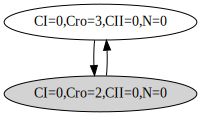

In [21]:
phage.having(attractors[0]["sample"]).reachable_stategraph() # display the cyclic attractor

See the [Pint tutorial on state graph analysis](https://loicpauleve.name/pint/doc/stategraph.html) for more functions and examples.